In [50]:
!pip install langgraph langsmith langchain langchain_groq langchain_community

In [78]:
from typing import Annotated
from typing_extensions import TypedDict

In [3]:
!pip install arxiv wikipedia

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 6.3 MB/s eta 0:00:00
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=24a4fd69598f45e167198028ba7ca6d7cbd1993a095a4a4602efefc5060556ad
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=6cf364f7f1a2069f1ca50f8803a8258542145e2fa4f7be0d88bc8f406b2b4b37
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built wikipedia sgmllib3k


In [79]:
#importing external tools
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

#Calling Tools
arxiv_wrapper = ArxivAPIWrapper(top_k_results= 1, doc_content_chars_max= 300)
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper = WikipediaAPIWrapper(top_k_results= 1, doc_content_chars_max= 300)
wiki_tool = WikipediaAPIWrapper(api_wrapper=api_wrapper)

In [10]:
!pip install --upgrade langchain


In [80]:
wiki_tool.run("Who is Tomcruise?")

'Page: Tom Cruise\nSummary: Thomas Cruise Mapother IV (born July 3, 1962) is an American actor and producer. Regarded as a Hollywood icon, he has received various accolades, including an Honorary Palme d\'Or and three Golden Globe Awards, in addition to nominations for four Academy Awards. His films have grossed over $12 billion worldwide, placing him among the highest-grossing actors of all time. One of Hollywood\'s most bankable stars, he is consistently one of the world\'s highest-paid actors.\nCruise began acting in the early 1980s and made his breakthrough with leading roles in Risky Business (1983) and Top Gun (1986). Critical acclaim came with his roles in the dramas The Color of Money (1986), Rain Man (1988), and Born on the Fourth of July (1989). For his portrayal of Ron Kovic in the latter, he won a Golden Globe Award and received a nomination for the Academy Award for Best Actor. As a leading Hollywood star in the 1990s, he starred in commercially successful films, including

In [81]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [82]:
tools = [wiki_tool]

In [83]:
# Langgraph Application
from langgraph.graph.message import add_messages
class State(TypedDict):
  messages: Annotated[list, add_messages]

In [84]:
from langgraph.graph import StateGraph, START, END

In [85]:
graphbuilder = StateGraph(State)

In [86]:
#LLM Models
from langchain_groq import ChatGroq

In [87]:
from google.colab import userdata
groq_api_key=userdata.get("Langgraphgroqkey")

In [88]:
llm = ChatGroq(groq_api_key=groq_api_key, model_name = "Gemma2-9b-It")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7a8671cebb80>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7a86711b26b0>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [89]:
#tools = [wiki_search]

from langchain.tools import Tool

# Create a Tool object for your WikipediaAPIWrapper:
wiki_tool_for_llm = Tool(
    name="Wikipedia",
    func=wiki_tool.run,
    description="Useful for when you need to answer questions about real-world topics. Input should be a search query."
)

# Now bind the tools using the Tool object:
llm_tools = llm.bind_tools(tools=[wiki_tool_for_llm])



In [90]:
def chatbot(state: State):
  return {"messages":[llm_tools.invoke(state["messages"])]}

In [91]:
from langgraph.prebuilt import ToolNode,tools_condition

In [92]:
if "chatbot" not in graphbuilder.nodes:
  graphbuilder.add_node("chatbot", chatbot)
else:
  print("Node 'chatbot' already exists in the graph. Skipping addition.")

#graphbuilder.add_node("chatbot", chatbot)
graphbuilder.add_edge(START,"chatbot")
tool_node = ToolNode(tools=[wiki_tool_for_llm])
graphbuilder.add_node("tools",tool_node)

graphbuilder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graphbuilder.add_edge("tools","chatbot")
graphbuilder.add_edge("chatbot",END)


In [93]:
graph = graphbuilder.compile()

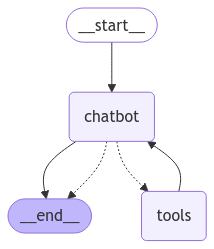

In [94]:
from IPython.display import display, Image

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:

  pass

In [95]:
#testing
user_input = "Hello, This is Sandeep Kummarapurugu "

events = graph.stream(
    {"messages":[{"role": "user", "content": user_input}]}, stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hello, This is Sandeep Kummarapurugu 
================================== Ai Message ==================================
Tool Calls:
  Wikipedia (call_dras)
 Call ID: call_dras
  Args:
    __arg1: Sandeep Kummarapurugu
================================= Tool Message =================================
Name: Wikipedia

No good Wikipedia Search Result was found
================================== Ai Message ==================================
Tool Calls:
  Wikipedia (call_559s)
 Call ID: call_559s
  Args:
    __arg1: Sandeep Kummarapurugu Sandeep Kummarapurugu is a Telugu film director, producer, and writer.
================================= Tool Message =================================
Name: Wikipedia

No good Wikipedia Search Result was found
================================== Ai Message ==================================

It appears there isn't much publicly available information about Sandeep Kummarapurugu.  

In [96]:
user_input = "Hello, Tell me about BERT transformer"

events = graph.stream(
    {"messages":[{"role": "user", "content": user_input}]}, stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hello, Tell me about BERT transformer
================================== Ai Message ==================================
Tool Calls:
  Wikipedia (call_jsv1)
 Call ID: call_jsv1
  Args:
    __arg1: BERT transformer
================================= Tool Message =================================
Name: Wikipedia

Page: Transformer (deep learning architecture)
Summary: A transformer is a deep learning architecture that was developed by researchers at Google and is based on the multi-head attention mechanism, which was proposed in the 2017 paper "Attention Is All You Need". Text is converted to numerical representations called tokens, and each token is converted into a vector via lookup from a word embedding table. At each layer, each token is then contextualized within the scope of the context window with other (unmasked) tokens via a parallel multi-head attention mechanism, allowing the signal for key tokens t

In [98]:
user_input = "Hello, Explain about ai"

events = graph.stream(
    {"messages":[{"role": "user", "content": user_input}]}, stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hello, Explain about ai
================================== Ai Message ==================================
Tool Calls:
  Wikipedia (call_rw93)
 Call ID: call_rw93
  Args:
    __arg1: artificial intelligence
================================= Tool Message =================================
Name: Wikipedia

Page: Artificial intelligence
Summary: Artificial intelligence (AI), in its broadest sense, is intelligence exhibited by machines, particularly computer systems. It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goals. Such machines may be called AIs.
High-profile applications of AI include advanced web search engines (e.g., Google Search); recommendation systems (used by YouTube, Amazon, and Netflix); virtual assistan